In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import EfficientNetV2L
from keras.applications import ResNet50
from keras.applications.efficientnet_v2 import preprocess_input
data_augmentation = Sequential([layers.RandomFlip("horizontal"), layers.RandomRotation(0.1)])

In [ ]:
folder = '/content/drive/MyDrive/training_faces_2'
all_images = os.listdir('/content/drive/MyDrive/training_faces_2')
unique_names = set([' '.join(all_images[i].split('_')[:2]) for i in range(len(all_images))])
img_label = dict()
for i in range(len(unique_names)):
    img_label[list(unique_names)[i]] = i

images_data = pd.DataFrame()
images = []

for i in tqdm(range(len(all_images))):
  image_name = ' '.join(all_images[i].split('_')[:2])
  label = img_label[image_name]
  image_path = folder + '/' + all_images[i]

  image = cv2.imread(image_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image.astype('float32')
  image /= 255
  image = cv2.resize(image, (110,110))
  image = image.astype('float32')

  images_data.loc[i, 'Name'] = image_name
  images.append(image)
  images_data.loc[i, 'Label'] = label
  images_data.loc[i, 'Path'] = image_path

images_data['Image'] = images
images_data['Label'] = images_data['Label'].astype('str')
images_data.head()

100%|██████████| 5600/5600 [00:22<00:00, 249.63it/s]


,Name,Label,Path,Image
0,Keith Bogans,392.0,/content/drive/MyDrive/training_faces_2/Keith_...,"[[[0.01191768, 0.99994814, 1.037109e-05], [0.0..."
1,Kelly Clarkson,226.0,/content/drive/MyDrive/training_faces_2/Kelly_...,"[[[0.019607844, 1.0, 0.011764706], [0.00026737..."
2,Keanu Reeves,96.0,/content/drive/MyDrive/training_faces_2/Keanu_...,"[[[0.0002775077, 0.99998987, 9.925458e-05], [0..."
3,Keira Knightley,43.0,/content/drive/MyDrive/training_faces_2/Keira_...,"[[[0.0005289256, 0.99997085, 0.000112785616], ..."
4,Keanu Reeves,96.0,/content/drive/MyDrive/training_faces_2/Keanu_...,"[[[0.015005105, 0.9955873, 0.022345165], [0.00..."


In [ ]:
def make_pairs(data):
  pairs = []
  labels = []
  for i in range(len(data['Name'])):
    current_label = data.loc[i, 'Label']
    pos_candidates = np.array(data.loc[data['Label'] == current_label, 'Image'])
    pos_choice = np.random.choice(pos_candidates)
    pairs.append([data.loc[i, 'Image'], pos_choice])
    labels.append([1])

    neg_candidates = np.array(data.loc[data['Label'] != current_label, 'Image'])
    neg_choice = np.random.choice(neg_candidates)
    pairs.append([data.loc[i, 'Image'], neg_choice])
    labels.append([0])
  return (np.array(pairs), np.array(labels))

In [ ]:
def create_model(inputShape, embeddingDim=48):
  # specify the inputs for the feature extractor network
  inputs = Input(inputShape)
  # define the first set of CONV => RELU => POOL => DROPOUT layers
  x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.3)(x)
  # second set of CONV => RELU => POOL => DROPOUT layers
  x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Dropout(0.3)(x)
  # prepare the final outputs
  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)
  # build the model
  model = Model(inputs, outputs)
  # return the model to the calling function
  return model

In [ ]:
def create_model_2(inputShape, embeddingDim=48):
  base_model = ResNet50(weights='imagenet',input_shape=(110, 110, 3), include_top=False)
  base_model.trainable = False #freeze parameters of imported model
  inputs = Input(shape=(110, 110, 3)) #define input shape (it must be in line with that passed to the model above)
  x = data_augmentation(inputs)
  x = base_model(x, training=False) #use as base_model the imported one
  x = GlobalAveragePooling2D()(x) #add pooling layer
  x = Dropout(0.3)(x) #drop 30% of parameters
  outputs = Dense(embeddingDim)(x)
  model = Model(inputs, outputs) #put everything together
  return model

In [ ]:
def euclidean_distance(vectors):
  # unpack the vectors into separate lists
  (featsA, featsB) = vectors
  # compute the sum of squared distances between the vectors
  sumSquared = K.sum(K.square(featsA - featsB), axis=1,
  keepdims=True)
  # return the euclidean distance between the vectors
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
img_shape = (110,110,3)
feature_extractor = create_model(img_shape)
imgA = Input(shape = img_shape)
imgB = Input(shape = img_shape)
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

distance = Lambda(euclidean_distance)([featA, featB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs = outputs)

In [ ]:
def plot_training(H):
# construct a plot that plots and saves the training history
  #plt.style.use("ggplot")
  plt.figure()
  plt.plot(H.history["loss"], label="train_loss")
  plt.plot(H.history["val_loss"], label="val_loss")
  plt.plot(H.history["accuracy"], label="train_acc")
  plt.plot(H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")
  plt.show()

In [ ]:
(all_pairs, all_labels) = make_pairs(images_data)

In [ ]:
val_percentage = 0.2
val_num = int(len(all_pairs)*val_percentage)

val_index = np.random.choice(np.arange(len(all_pairs)), size = val_num)

val_pairs = all_pairs[val_index]
val_labels = all_labels[val_index]

train_pairs = []
train_labels = []
for i in range(len(all_pairs)):
  if i not in val_index:
    train_pairs.append(all_pairs[i])
    train_labels.append(list(all_labels[i]))

train_pairs = np.array(train_pairs)
train_labels = np.array(train_labels)

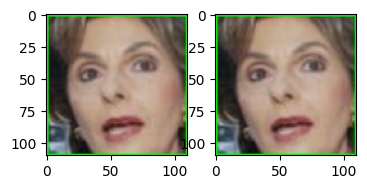

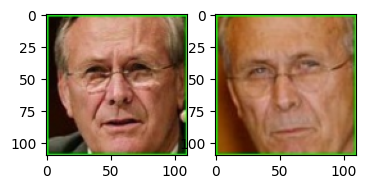

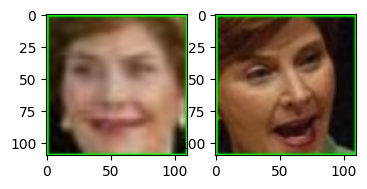

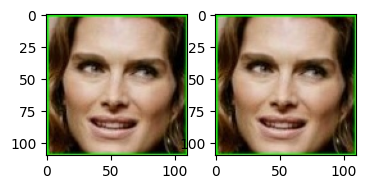

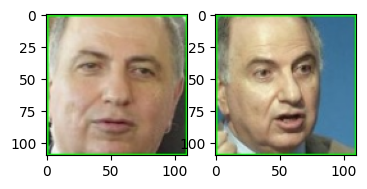

In [ ]:
positive = np.random.choice(np.where(train_labels == [1])[0], size = 5)
for index in positive:
  plt.figure(figsize=(4, 2))
  pair = train_pairs[index]
  for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.imshow(pair[i])
  plt.show()

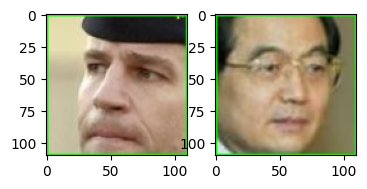

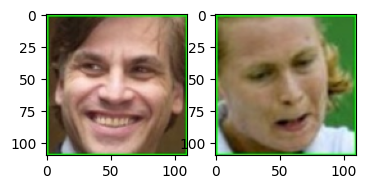

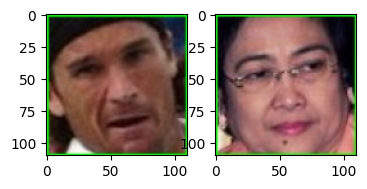

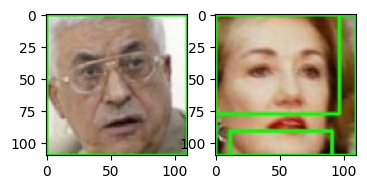

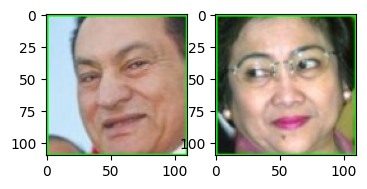

In [ ]:
negative = np.random.choice(np.where(train_labels == [0])[0], size = 5)
for index in negative:
  plt.figure(figsize=(4, 2))
  pair = train_pairs[index]
  for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.imshow(pair[i])
  plt.show()

In [ ]:
def togpu(img):
    with tf.device('/gpu:0'):
        tens_data = tf.constant(img)
    return tens_data

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2, preprocessing_function = togpu)
batch_s = 64

train_generator = datagen.flow_from_dataframe(
    images_data,
    x_col = 'Path',
    y_col = 'Label',
    class_mode = 'categorical',
    target_size = (110, 110),
    batch_size = batch_s,
    subset = 'training')

validation_generator = datagen.flow_from_dataframe(
    images_data,
    x_col = 'Path',
    y_col = 'Label',
    class_mode = 'categorical',
    target_size = (110, 110),
    batch_size = batch_s,
    subset = 'validation')

def siamese_generator(generator):
    while True:
        x, y = next(generator)
        n_samples = x.shape[0]
        pairs = []
        labels = []
        for i in range(n_samples):
            for j in range(i+1, n_samples):
                if y[i][0] == y[j][0]:
                    labels.append([1])
                else:
                    labels.append([0])
                pairs.append([x[i], x[j]])
        pairs = np.array(pairs)
        labels = np.array(labels)
        yield [pairs[:, 0], pairs[:, 1]], labels[:]

Found 4480 validated image filenames belonging to 1148 classes.
Found 1120 validated image filenames belonging to 1148 classes.


In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
history = model.fit(siamese_generator(train_generator),
                    steps_per_epoch = train_generator.samples // train_generator.batch_size,
                    validation_data = siamese_generator(validation_generator),
                    validation_steps = validation_generator.samples // validation_generator.batch_size)

'''history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels[:],
                    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels[:]),
                    batch_size = 64,
                    epochs= 10)'''

In [ ]:
plot_training(history)